Импорт библиотек

In [ ]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from numpy import fft

Определяем функции рисования графиков

In [ ]:
def plotter(draw, value_blue, legends, ylabel, fig_name):
    plt.plot(value_blue[0:draw], 'b')
    plt.legend(legends)
    plt.xlabel("discrete time, k")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(fig_name, format="eps")
    plt.show()


def plotter2(draw, value_blue, value_red, legends, ylabel, fig_name):
    plt.plot(value_blue[0:draw], 'b')
    plt.plot(value_red[0:draw], 'r', linewidth=2.0)
    plt.legend(legends)
    plt.xlabel("discrete time, k")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.savefig(fig_name, format="eps")
    plt.show()

Определяем фильтры

In [ ]:
# Порядок фильтров
M = 10


def LMS(input_signal, desired_signal, k_mu=0.95):
    # количество измерений
    N = len(input_signal)
    # Расчетные параметры алгоритма
    # СКО
    sigma2 = np.var(input_signal)
    print(sigma2)  # 0.175805
    # Шаг сходимости. Задает скорость обучения. Принимает значения от 0 до 1/(3*M*sigma2)
    mu_max = 1 / (3 * M * sigma2)
    print(mu_max) # 0.189603
    mu = mu_max * k_mu  # чем ближе к максимуму, тем лучше

    # Инициализация весов фильтра
    w = np.zeros(M)

    # Применение алгоритма
    output_signal = np.zeros(N)  # выход
    error = np.zeros(N)  # ошибка
    W = np.zeros((M, N))  # веса

    for i in range(M, N):
        x = input_signal[i : i - M : -1]
        y = w @ x.T
        e = desired_signal[i] - y
        w = w + mu * e * x

        output_signal[i] = y
        error[i] = e
        W[:, i] = w

    return output_signal


def NLMS(input_signal, desired_signal, k_mu=0.95, k_delta2=1.5):
    # количество измерений
    N = len(input_signal)
    # Расчетные параметры алгоритма
    #СКО
    sigma2 = np.var(input_signal)
    print(sigma2)  # 0.175805
    # Шаг сходимости. Задает скорость обучения. Принимает значения от 0 до 1/(3*M*sigma2)
    mu_max = 1 / (3 * M * sigma2)
    print(mu_max) # 0.189603
    mu = mu_max * k_mu
    # delta2 > 0.01*sigma_x^2
    delta2 = k_delta2 * 0.01*sigma2

    # Инициализация весов фильтра
    w = np.zeros(M)

    # Применение алгоритма
    output_signal = np.zeros(N)  # выход
    error = np.zeros(N)  # ошибка
    W = np.zeros((M, N))  # веса

    for i in range(M, N):
        x = input_signal[i : i - M : -1]
        y = w @ x.T
        e = desired_signal[i] - y
        w = w + (2 * mu / x.T @ x + delta2) * e * x

        output_signal[i] = y
        error[i] = e
        W[:, i] = w

    return output_signal


def RLS(input_signal, desired_signal):
    # количество измерений
    N = len(input_signal)
    # Расчетные параметры алгоритма
    sigma2 = np.var(input_signal)  # СКО
    # инициализация R: delta2 > 0.01*sigma_x^2
    # Вопрос инициализации матрицы R рассматривается в главе 14.8
    delta2 = 100 * 0.01*sigma2
    inv_R0 = np.eye(M) * (1 / delta2)
    inv_R = inv_R0

    # Инициализация весов фильтра
    w = np.zeros(M)

    # Применение алгоритма
    output_signal = np.zeros(N)  # выход
    error = np.zeros(N)  # ошибка
    W = np.zeros((M, N))  # веса

    for i in range(M, N):
        x = input_signal[i : i - M : -1]
        y = w @ x.T
        e = desired_signal[i] - y
        K = inv_R @ x
        w = w + K.T * e / (x.T @ inv_R @ x)
        inv_R = inv_R - K * x * inv_R

        output_signal[i] = y
        error[i] = e
        W[:, i] = w

    return output_signal


def FFRLS(input_signal, desired_signal):
    # количество измерений
    N = len(input_signal)
    # Расчетные параметры алгоритма
    sigma2 = np.var(input_signal)  # СКО
    # инициализация R: delta2 > 0.01*sigma_x^2
    # Вопрос инициализации матрицы R рассматривается в главе 14.8
    delta2 = 100 * 0.01*sigma2
    inv_R0 = np.eye(M) * (1 / delta2)
    inv_R = inv_R0
    # 1-0.4/M <= lamda <= 1
    lamda = 0.996  # Коэффициент забывания

    # Инициализация весов фильтра
    w = np.zeros(M)

    # Применение алгоритма
    output_signal = np.zeros(N)  # выход
    error = np.zeros(N)  # ошибка
    W = np.zeros((M, N))  # веса

    for i in range(M, N):
        x = input_signal[i : i - M : -1]
        y = w @ x.T
        e = desired_signal[i] - y
        K = inv_R @ x / (lamda + x.T @ inv_R @ x)
        w = w + K.T * e;
        inv_R = (inv_R - K * x * inv_R) / lamda;

        output_signal[i] = y
        error[i] = e
        W[:, i] = w

    return output_signal

Задаем параметры моделирования

In [ ]:
fs = 1000  # частота дискретизации
dt = 1/fs
t_end = 100
k = np.linspace(0, t_end, fs)

# Аккорд ля Мажор
f1 = 440
f2 = 550
f3 = 660
desired_signal = np.sin(2*pi*f1*k) + np.sin(2*pi*f2*k) + np.sin(2*pi*f3*k)
desired_signal /= 3

# сигнальчик для RusAutoCon
f1 = 1
f2 = 10
desired_signal = np.sin(2*pi*f1*k) + np.sin(2*pi*f2*k)


# Задаем характеристики шума
mean = 0
sigma_2 = 0.1  # СКО
gaussian_noise = np.random.normal(mean, sigma_2, len(k))

# формируем сигнал
input_signal = desired_signal + gaussian_noise

# Сколько рисуем точек?
draw = len(input_signal)//10*10
draw

1000

Рисуем входной сигнал

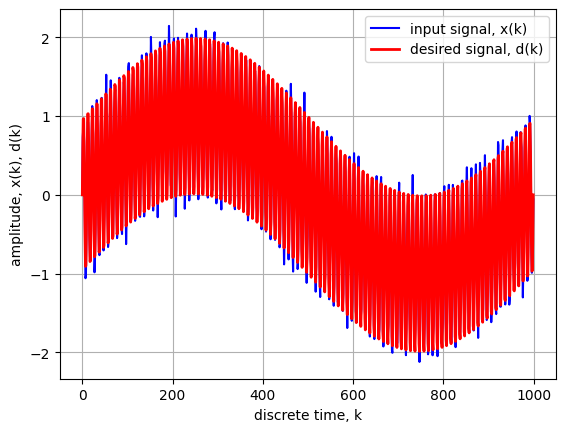

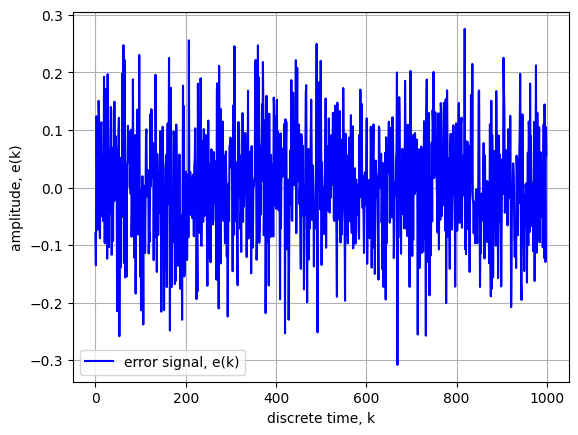

In [ ]:
plotter2(draw, input_signal, desired_signal, ["input signal, x(k)", "desired signal, d(k)"], "amplitude, x(k), d(k)", "signals.svg")
plotter(draw, desired_signal - input_signal, ["error signal, e(k)"], "amplitude, e(k)", "signals-error.svg")

Результаты фильтрации

1.008153727672229
0.03306374059668276
1.008153727672229
0.03306374059668276


<ipython-input-3-f12e06a9595c>:62: RuntimeWarning: overflow encountered in matmul
  y = w @ x.T
<ipython-input-3-f12e06a9595c>:62: RuntimeWarning: invalid value encountered in matmul
  y = w @ x.T
<ipython-input-3-f12e06a9595c>:98: RuntimeWarning: overflow encountered in multiply
  inv_R = inv_R - K * x * inv_R
<ipython-input-3-f12e06a9595c>:97: RuntimeWarning: invalid value encountered in divide
  w = w + K.T * e / (x.T @ inv_R @ x)
<ipython-input-3-f12e06a9595c>:98: RuntimeWarning: invalid value encountered in multiply
  inv_R = inv_R - K * x * inv_R


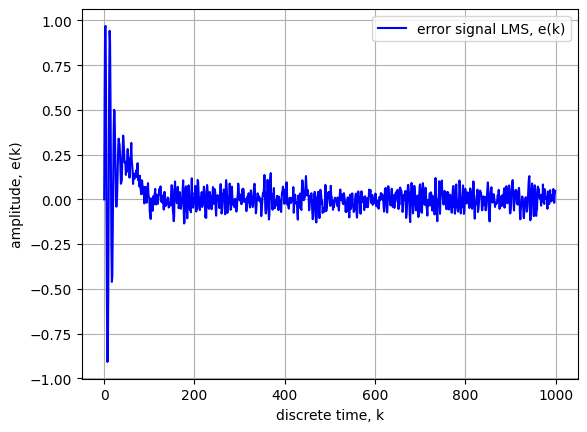

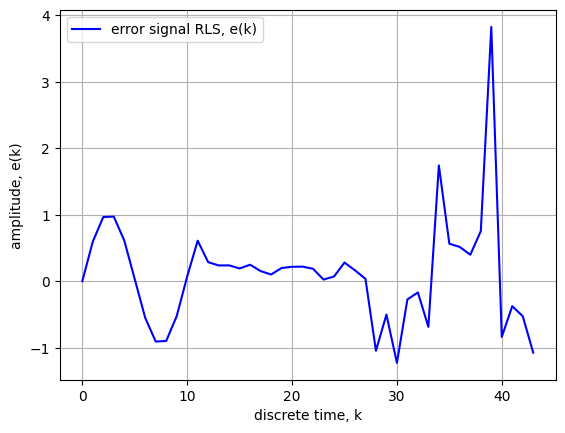

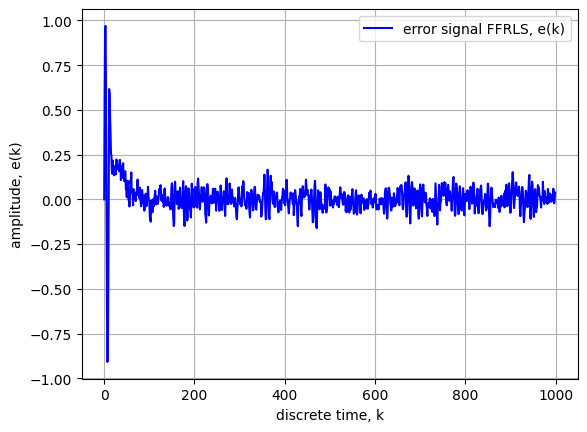

In [ ]:
output_signal_LMS = LMS(input_signal, desired_signal)
output_signal_NLMS = NLMS(input_signal, desired_signal)
output_signal_RLS = RLS(input_signal, desired_signal)
output_signal_FFRLS = FFRLS(input_signal, desired_signal)

plotter(draw, desired_signal - output_signal_LMS, ["error signal LMS, e(k)"], "amplitude, e(k)", "LMS-error.eps")
#plotter(draw, desired_signal - output_signal_NLMS, ["error signal NLMS, e(k)"], "amplitude, e(k)", "NLMS-error.eps")
plotter(draw, desired_signal - output_signal_RLS, ["error signal RLS, e(k)"], "amplitude, e(k)", "RLS-error.eps")
plotter(draw, desired_signal - output_signal_FFRLS, ["error signal FFRLS, e(k)"], "amplitude, e(k)", "FFRLS-error.eps")

Частотный анализ

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


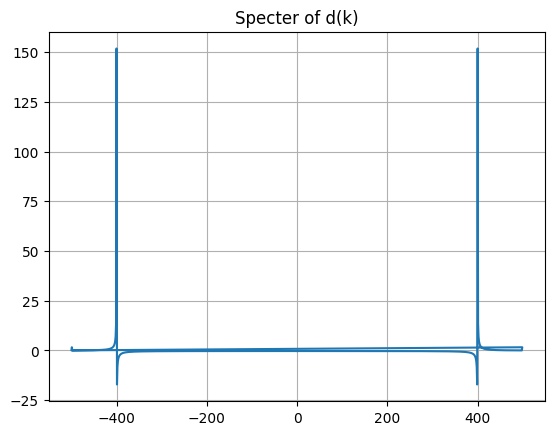

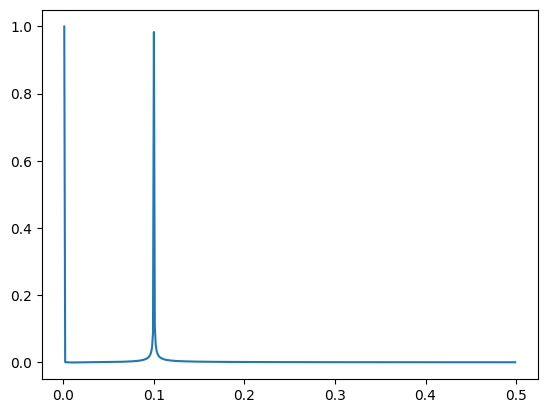

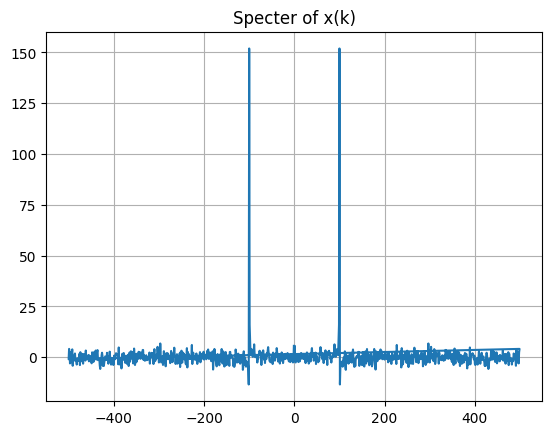

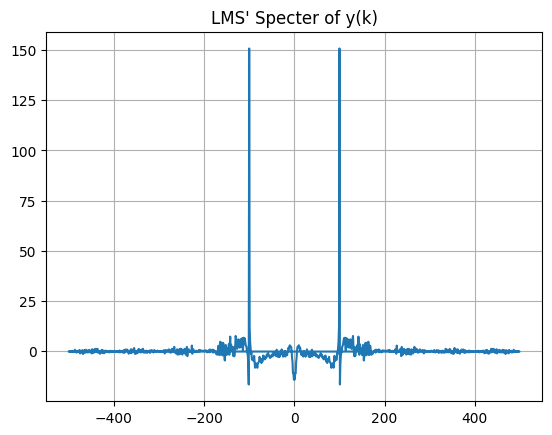

In [ ]:
freq = fft.fftfreq(len(k), dt)

fourier_desired_signal = fft.fft(desired_signal)
plt.plot(freq, fft.fftshift((fourier_desired_signal)))
plt.title("Specter of d(k)")
plt.grid(True)
plt.show()

# True theoretical FFT
freqs = fft.fftfreq(len(k))
mask = freqs > 0
fft_vals = fft.fft(desired_signal)
fft_theo = 2.0*np.abs(fft_vals/len(k))
plt.plot(freqs[mask][:], fft_theo[mask][:])
plt.show()


fourier_input_signal = fft.fft(input_signal)
plt.plot(freq, fourier_input_signal)
plt.title("Specter of x(k)")
plt.grid(True)
plt.show()

plt.plot(freq, fft.fft(output_signal_LMS))
plt.title("LMS' Specter of y(k)")
plt.grid(True)
plt.show()

Нестационарный сигнал

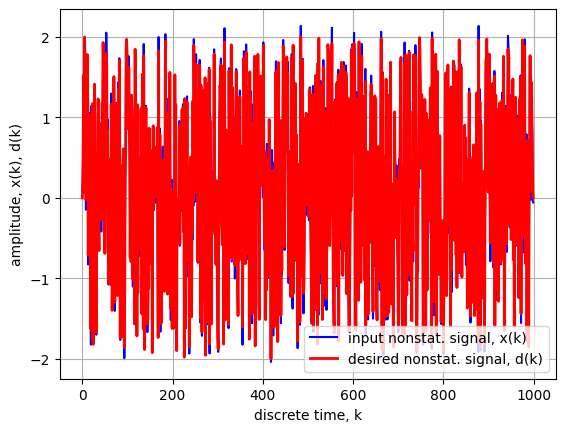

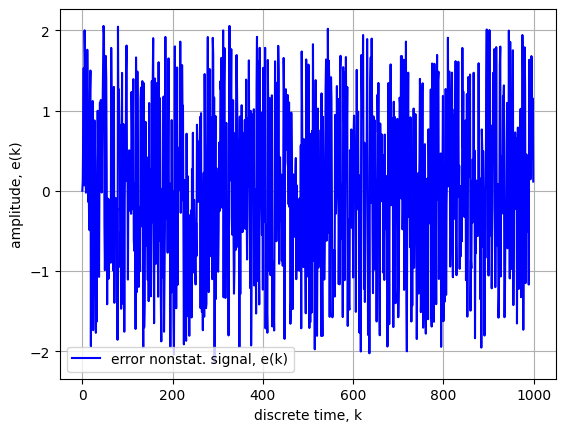

In [ ]:
# Создание нестационарного сигнала (сумма гармонических сигналов с изменяющимися частотами)
nonstationary_desired_signal = np.sin(2*pi*(f1*k)*k) + np.sin(2*pi*k*k*f2*k)
nonstationary_input_signal = nonstationary_desired_signal + gaussian_noise

plotter2(draw, nonstationary_input_signal, nonstationary_desired_signal, ["input nonstat. signal, x(k)", "desired nonstat. signal, d(k)"], "amplitude, x(k), d(k)", "nonstat-signals.eps")
plotter(draw, nonstationary_desired_signal - output_signal_LMS, ["error nonstat. signal, e(k)"], "amplitude, e(k)", "nonstat-signals-error.eps")


Фильтрация нестационарного сигнала

<ipython-input-3-f12e06a9595c>:62: RuntimeWarning: overflow encountered in matmul
  y = w @ x.T
<ipython-input-3-f12e06a9595c>:62: RuntimeWarning: invalid value encountered in matmul
  y = w @ x.T
<ipython-input-3-f12e06a9595c>:98: RuntimeWarning: overflow encountered in multiply
  inv_R = inv_R - K * x * inv_R
<ipython-input-3-f12e06a9595c>:97: RuntimeWarning: invalid value encountered in divide
  w = w + K.T * e / (x.T @ inv_R @ x)
<ipython-input-3-f12e06a9595c>:98: RuntimeWarning: invalid value encountered in multiply
  inv_R = inv_R - K * x * inv_R


1.0194274298482007
0.032698093417298846
1.0194274298482007
0.032698093417298846


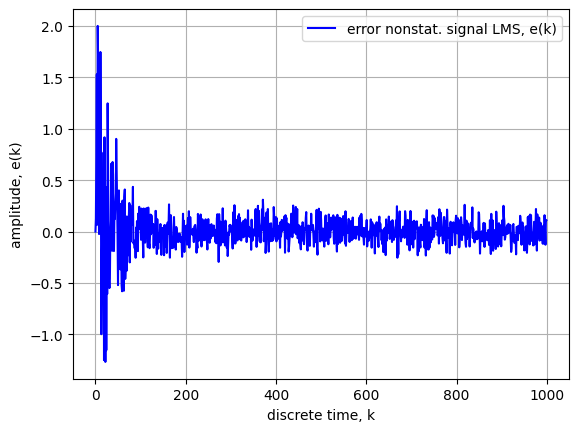

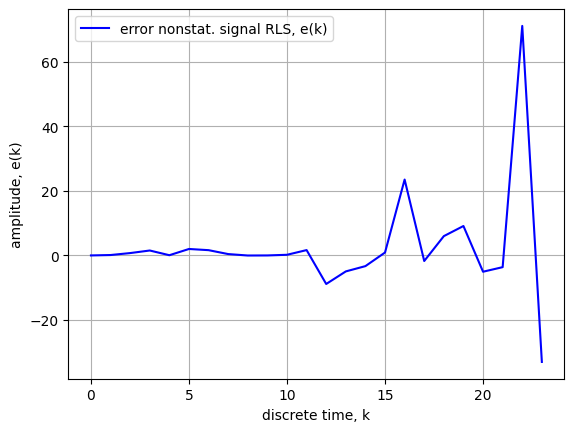

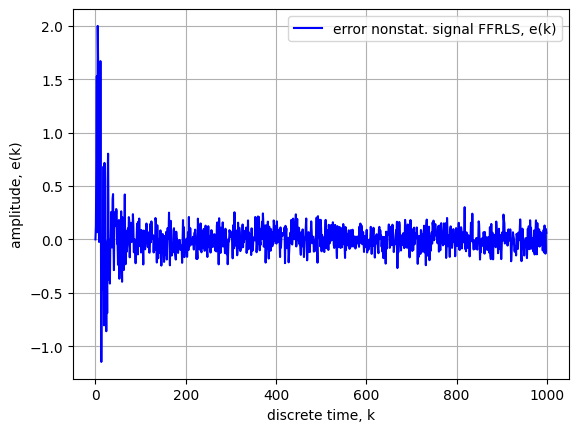

In [ ]:
output_signal_LMS = LMS(nonstationary_input_signal, nonstationary_desired_signal)
output_signal_NLMS = NLMS(nonstationary_input_signal, nonstationary_desired_signal)
output_signal_RLS = RLS(nonstationary_input_signal, nonstationary_desired_signal)
output_signal_FFRLS = FFRLS(nonstationary_input_signal, nonstationary_desired_signal)

plotter(draw, nonstationary_desired_signal - output_signal_LMS, ["error nonstat. signal LMS, e(k)"], "amplitude, e(k)", "nonstat-LMS-error.eps")
# plotter(draw, nonstationary_desired_signal - output_signal_NLMS, ["error nonstat. signal NLMS, e(k)"], "amplitude, e(k)", "nonstat-NLMS-error.eps")
plotter(draw, nonstationary_desired_signal - output_signal_RLS, ["error nonstat. signal RLS, e(k)"], "amplitude, e(k)", "nonstat-RLS-error.eps")
plotter(draw, nonstationary_desired_signal - output_signal_FFRLS, ["error nonstat. signal FFRLS, e(k)"], "amplitude, e(k)", "nonstat-FFRLS-error.eps")

НС

In [ ]:
#import tensorflow as tf
from sklearn.model_selection import train_test_split


# Создание трехслойной нейронной сети
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


X_train = input_signal[0:901]
y_train = desired_signal[0:901]

X_train, X_test, y_train, y_test = train_test_split(input_signal, desired_signal, train_size=0.6, random_state=42, shuffle=False)

# Обучение модели
model.fit(X_train, y_train, epochs=10)

# Пример предсказания на новых данных
X_new = input_signal[901:1901]
prediction = model.predict(X_test)
print(len(prediction))

# Рисуем график ошибки
plt.plot(prediction - desired_signal[901:], 'b')
plt.xlabel("discrete time, k")
plt.ylabel("amplitude, e(k)")
plt.legend(["signal error NN e(k)"])
plt.grid(True)
#plt.savefig("NN-error.png", format="png")
plt.show()

In [ ]:
# Рисуем график ошибки
plt.plot(prediction[:1001] - y_test[:1001], 'b')
plt.xlabel("discrete time, k")
plt.ylabel("amplitude, e(k)")
plt.legend(["signal error NN e(k)"])
plt.grid(True)
#plt.savefig("NN-error.png", format="png")
plt.show()